In [2]:
# !pip3 install two-sample-binomial
# !pip3 install multiple-hypothesis-testing

import numpy as np
import scipy

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['figure.figsize'] =  [8, 6]
mpl.style.use('ggplot')
%matplotlib inline
from tqdm import tqdm
import pandas as pd

from survival import *

from illustrate_gene_expression_survival_curves import illustrate_survival_curve_time2event
from test_gene_expression import reduce_time_resolution

## Load raw data:

In [3]:
fn = "./Data/SCANB_groups.csv"
df = pd.read_csv(fn)
gene_names = [c for c in df.columns if c not in ['Unnamed: 0', 'time', 'event']]

print(f"Read group partition based on median expression level of {len(gene_names)} genes.")

print("Removing genese with repeating median entries...")
div_probs = df.agg(['mean'])
thresh = 0.001
valid_genes0 = [g for g in gene_names if np.abs(div_probs[g]['mean'] - 0.5) < thresh]
invalid_genes = [g for g in gene_names if np.abs(div_probs[g]['mean'] - 0.5) > thresh]
df = df.drop(columns = invalid_genes + ['Unnamed: 0'])

print("Removed: ", len(gene_names) - len(valid_genes0), " genes.")

FileNotFoundError: [Errno 2] No such file or directory: './Data/SCANB_groups.csv'

### Filter cases of non-equal survival distribution
The following part test for equality of the distribution of censoring events in both groups. In the case of a different censoring distribution, the permutation test may be invalid as explained in:
- Heimann, G., and Georg Neuhaus. "Permutational distribution of the log-rank statistic under random censorship with applications to carcinogenicity assays." Biometrics (1998): 168-184.



In [140]:
# test for equality of censoring distribution

from tqdm import tqdm 
from scipy.stats import ks_2samp, ttest_ind, ranksums
# Perform Kolmogorov-Smirnoff test

def qqplot(t1, t2):
    qq = np.linspace(0,1, 100)
    q1 = [np.quantile(t1 , q) for q in qq]
    q2 = [np.quantile(t2 , q) for q in qq]
    
    plt.figure()
    plt.scatter(q1, q2)
    # y=x line:
    plt.plot([0, max(q1)], [0, max(q2)], 'r', alpha=0.5)



def two_sample_tests(t1, t2): 

    # Wilcoxon rank-sum test:
    _, w_pvalue = ranksums(t1, t2)

    # Kolmogorov-Smirnov test:    
    _, ks_pvalue = ks_2samp(t1, t2)
    
    # two-sample t-test: 
    _, t_pvalue = ttest_ind(t1, t2)

    return {'w_pvalue': w_pvalue, 'ks_pvalue': ks_pvalue, 't_pvalue': t_pvalue}


dfc = df[df['event'] == 0].sort_values(by = 'time')
dfc = dfc[dfc.time > 800]

res = {}
acc = 0
print("Tesitng for equality among censoring distribution:")
for gene_name in tqdm(valid_genes0):    
    dfx = dfc[dfc[gene_name] == 0].time.sort_values()
    dfy = dfc[dfc[gene_name] == 1].time.sort_values()
    t1 = dfx.tolist()
    t2 = dfy.tolist()
    res[gene_name] = two_sample_tests(t1, t2)
    if res[gene_name]['ks_pvalue'] < 0.05:
        acc += 1
    #     qqplot(t1, t2)
    #     plt.title(gene_name)
    #     plt.show()

valid_genes = [g for g in valid_genes0 if res[g]['ks_pvalue'] > 0.05]
filename = "./Data/SCANB_groups_valid_KS_censor.csv"
df[['time', 'event'] + valid_genes].to_csv(filename)
print(f"Saved data with {len(valid_genes)} genes to {filename}")

Tesitng for equality among censoring distribution:


100%|██████████| 8702/8702 [03:17<00:00, 44.08it/s]


Saved data with 4028 genes to ./Data/SCANB_groups_valid_KS_censor.csv


### Illustrate raw data

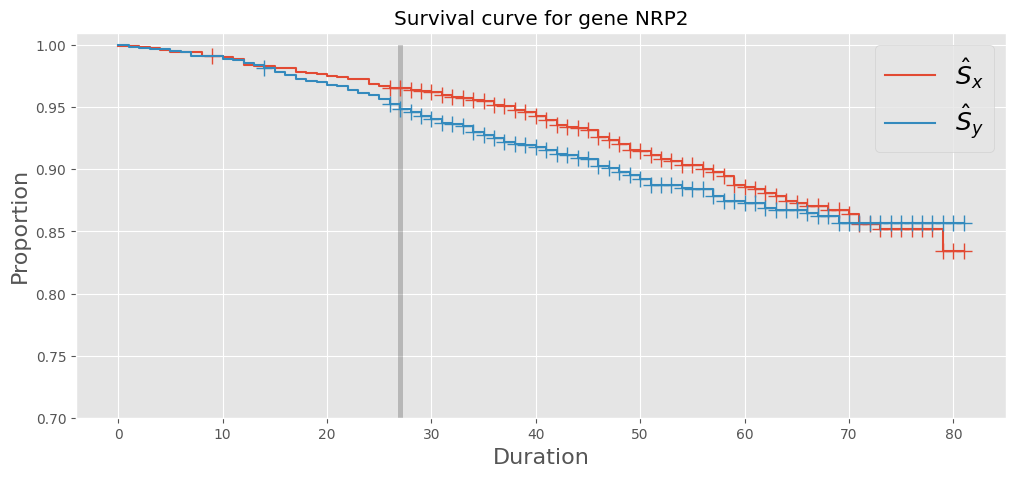

,at-risk1,at-risk2,events1,events2,pvalue,HCT
27,1470,1449,0,6,0.014885,True


In [141]:
plt.rcParams['figure.figsize'] =  [12, 5]

# Randomly choose one gene
gene_name = np.random.choice(valid_genes, 1)[0]

df_gene = df.filter([gene_name, 'time', 'event'])
df_gene_T = reduce_time_resolution(df_gene, T=82)
df_HCT, dfg = illustrate_survival_curve_time2event(df_gene_T.rename(columns={gene_name : 'group'}))
plt.title(f"Survival curve for gene {gene_name}")
plt.ylim([0.7,1.01])
plt.show()
df_HCT

## Read and report null values

In [6]:
def q95(x):
    """
    Compute the 95-th percentile of the vector x
    """
    if x.dtypes.kind == 'O':
        return np.nan
    else:
        return pd.Series.quantile(x, .95)

def q99(x):
    """
    Compute the 95-th percentile of the vector x
    """
    if x.dtypes.kind == 'O':
        return np.nan
    else:
        return pd.Series.quantile(x, .99)


In [7]:
T = 82
M = 1
stbl = True
from glob import glob

lo_files = glob("results/SCANB_null_stable_T82_rep1_all.csv")

print(lo_files)
df0 = pd.concat([pd.read_csv(f) for f in lo_files])
#a = df0.filter(['hc_greater', 'log_rank_greater', 'log_rank_pval_greater', 'hc_greater_rev', 'logrank_lifelines_None']).agg(['mean','std',q95, q99])
print("Overall number of null expriments found: ", len(df0))
a = df0.agg(['mean','std',q95, q99])
crit_vals = a.loc['q95'].to_dict()
a

['results/SCANB_null_stable_T82_rep1_all.csv']
Overall number of null expriments found:  10000


/var/folders/3n/c1thdb3136qc3c_4t5br9r6c0000gq/T/ipykernel_23765/2928084683.py:12: FutureWarning: ['name', 'name_rev'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  a = df0.agg(['mean','std',q95, q99])


,Unnamed: 0,log_rank_greater,log_rank_pval_greater,hc_greater,fisher_greater,min_p_greater,berk_jones_greater,logrank_lifelines_None,logrank_lifelines_wilcoxon,logrank_lifelines_tarone-ware,...,logrank_lifelines_tarone-ware_rev,logrank_lifelines_peto_rev,logrank_lifelines_fleming-harrington55_rev,logrank_lifelines_fleming-harrington11_rev,logrank_lifelines_fleming-harrington01_rev,chisq_test_stat_rev,lr_test_stat_rev,cauchy_test_stat_rev,name_rev,itr
mean,0.0,-0.012284,0.504967,-1.873556,85.881490,3.258658,19.177437,1.045263,1.040317,1.042872,...,1.042872,1.044825,1.046818,1.040400,1.040017,1.091478,1.101257,-5.297310e+15,NaN,4999.50000
std,0.0,0.994819,0.287963,1.642873,11.443150,0.833335,5.317398,1.489547,1.482710,1.486606,...,1.486606,1.488869,1.486791,1.471714,1.470934,0.838572,0.843962,5.436327e+15,NaN,2886.89568
q95,0.0,1.651811,0.948326,0.403947,105.513938,4.870665,28.168763,3.963634,3.924359,3.926482,...,3.926482,3.931461,4.066828,4.014688,4.008960,2.694153,2.709186,2.133980e+00,NaN,9499.05000
q99,0.0,2.314419,0.989984,0.767779,113.747879,5.576065,32.517441,7.040047,6.903440,7.013800,...,7.013800,7.054521,6.984218,6.820633,6.844340,4.325737,4.354236,1.330891e+01,NaN,9899.01000


In [144]:
output_dir = "/Users/kipnisal/Dropbox/Apps/Overleaf/Survival Analysis with Sensitivity to Possible Rare and Weak Differences/"
#output_dir = "./"

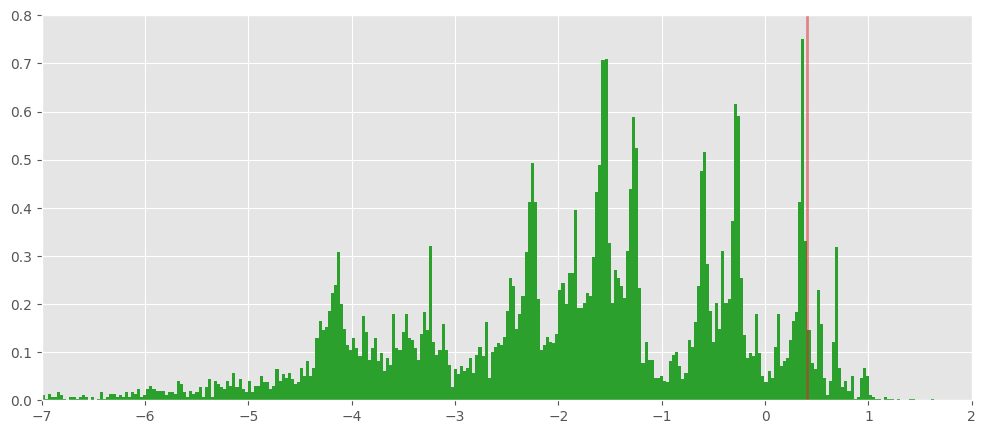

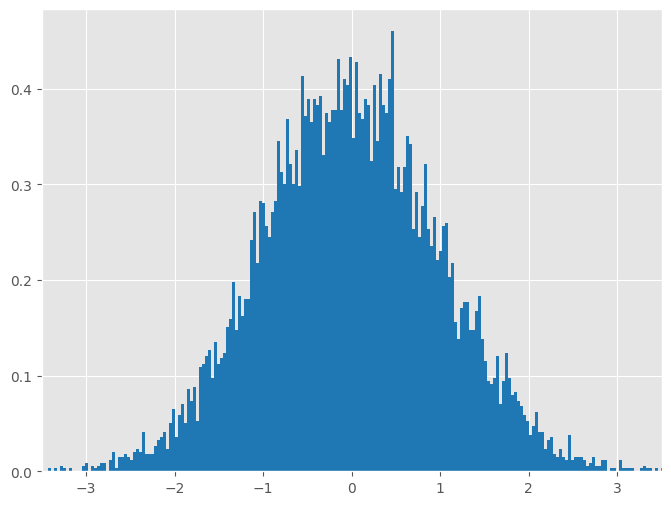

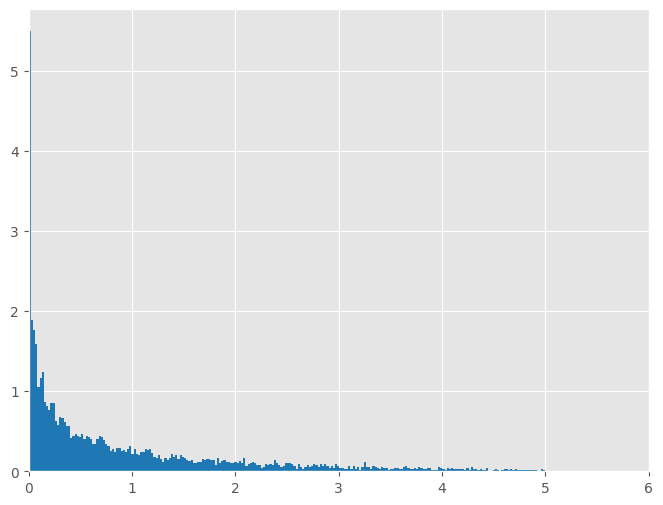

In [145]:
vals = list(df0.hc_greater)
plt.hist(vals, bins = np.linspace(-7,3,337), density=True, color='tab:green')
plt.rcParams['figure.figsize'] =  [8, 6]
plt.xlim([-7, 2])
plt.ylim([0, 0.8])
plt.vlines(crit_vals['hc_greater'], 0, 1, linewidth=2, color='tab:red', alpha=0.5, label='99% quantile')
#plt.text(crit_vals['hc_greater'] - 0.5, 0.45, "99% quantile", color='tab:red', backgroundcolor='white')

plt.savefig(output_dir + f'Figs/hc_hist_T{T}.png', dpi=180, bbox_inches='tight', pad_inches=0, transparent=True)
plt.show()

vals = list(df0.log_rank_greater) 
plt.hist(vals, bins = np.linspace(-4,4,237), density=True, color='tab:blue')
plt.rcParams['figure.figsize'] =  [8, 6]
plt.xlim([-3.5, 3.5])

plt.savefig(output_dir + 'Figs/lr_hist.png',dpi=180, bbox_inches='tight', pad_inches=0, transparent=True)
plt.show()

vals = list(df0.logrank_lifelines_None) 
plt.hist(vals, bins = np.linspace(0,5,237), density=True, color='tab:blue')
plt.rcParams['figure.figsize'] =  [8, 6]
plt.xlim([0, 6])

plt.savefig(output_dir + 'Figs/lr_chisq_hist.png', dpi=180, bbox_inches='tight', pad_inches=0, transparent=True)
plt.show()

## Analyze Results

Use script in ``test_gene_expression.py`` to get the results

In [ ]:
list_of_valid_genes = pd.read_csv('Data/SCANB_groups_valid_KS_censor.csv').drop(columns=['Unnamed: 0', 'time', 'event']).columns.tolist()

In [11]:
T = 82
result_file = f"results/SCANB_stable_T{T}.csv"
res = pd.read_csv(result_file)
# filter columns not in valid_genes:
res = res[res.name.isin(list_of_valid_genes)]
print(f"Using results of {len(res)} genes.")

NameError: name 'list_of_valid_genes' is not defined

In [9]:
# null values
from glob import glob

lo_files = glob("results/SCANB_null_stable_T82_rep1_all.csv")
print(lo_files)
df0 = pd.concat([pd.read_csv(f) for f in lo_files])
a = df0.agg(['mean','std',q95, q99])
crit_vals = a.loc['q95'].to_dict()
a

['results/SCANB_null_stable_T82_rep1_all.csv']


/var/folders/3n/c1thdb3136qc3c_4t5br9r6c0000gq/T/ipykernel_23765/1964999312.py:7: FutureWarning: ['name', 'name_rev'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  a = df0.agg(['mean','std',q95, q99])


,Unnamed: 0,log_rank_greater,log_rank_pval_greater,hc_greater,fisher_greater,min_p_greater,berk_jones_greater,logrank_lifelines_None,logrank_lifelines_wilcoxon,logrank_lifelines_tarone-ware,...,logrank_lifelines_tarone-ware_rev,logrank_lifelines_peto_rev,logrank_lifelines_fleming-harrington55_rev,logrank_lifelines_fleming-harrington11_rev,logrank_lifelines_fleming-harrington01_rev,chisq_test_stat_rev,lr_test_stat_rev,cauchy_test_stat_rev,name_rev,itr
mean,0.0,-0.012284,0.504967,-1.873556,85.881490,3.258658,19.177437,1.045263,1.040317,1.042872,...,1.042872,1.044825,1.046818,1.040400,1.040017,1.091478,1.101257,-5.297310e+15,NaN,4999.50000
std,0.0,0.994819,0.287963,1.642873,11.443150,0.833335,5.317398,1.489547,1.482710,1.486606,...,1.486606,1.488869,1.486791,1.471714,1.470934,0.838572,0.843962,5.436327e+15,NaN,2886.89568
q95,0.0,1.651811,0.948326,0.403947,105.513938,4.870665,28.168763,3.963634,3.924359,3.926482,...,3.926482,3.931461,4.066828,4.014688,4.008960,2.694153,2.709186,2.133980e+00,NaN,9499.05000
q99,0.0,2.314419,0.989984,0.767779,113.747879,5.576065,32.517441,7.040047,6.903440,7.013800,...,7.013800,7.054521,6.984218,6.820633,6.844340,4.325737,4.354236,1.330891e+01,NaN,9899.01000


In [150]:
# logrank_lifeline is chisquared with 1 dof
print("var: ", df0['logrank_lifelines_None'].var())
print("std: ", df0['logrank_lifelines_None'].std())
print("mean: ", df0['logrank_lifelines_None'].mean())
print("q95: ", df0['logrank_lifelines_None'].quantile(.95))

from scipy.stats import chi2
chi2.isf(0.05, 1)
chi2.moment(df=1, order=1)

var:  2.218751074863289
std:  1.4895472717786733
mean:  1.0452634388414725
q95:  3.963633880523735


1.0

In [151]:
STATS = ['hc_greater', 'hc_greater_rev', 'log_rank_greater', 'log_rank_greater_rev',
         'logrank_lifelines_None', 'logrank_lifelines_None_rev',
        'logrank_lifelines_wilcoxon', 'logrank_lifelines_wilcoxon_rev',
        'logrank_lifelines_tarone-ware', 'logrank_lifelines_tarone-ware_rev',
        'logrank_lifelines_peto', 'logrank_lifelines_peto_rev',
        'logrank_lifelines_fleming-harrington01', 'logrank_lifelines_fleming-harrington01_rev',
        'lr_test_stat', 'chisq_test_stat', 'cauchy_test_stat'
        ]


NAME_NEAT = {'hc_greater': "HCHG",
             'log_rank_greater': 'Log-rank',
        'logrank_lifelines_fleming-harrington01': 'Fleming-Harrington01',
        'logrank_lifelines_fleming-harrington01_rev': 'Fleming-Harrington01',
       'logrank_lifelines_fleming-harrington10': 'Fleming-Harrington10',
       'logrank_lifelines_fleming-harrington10_rev': 'Fleming-Harrington10',
       'logrank_lifelines_tarone-ware': 'Tarone-Ware',
       'logrank_lifelines_tarone-ware_rev': 'Tarone-Ware',
        'logrank_lifelines_peto': 'Peto',
        'logrank_lifelines_peto_rev': 'Peto',
        'logrank_lifelines_wilcoxon': 'Wilcoxon',
        'logrank_lifelines_wilcoxon_rev': 'Wilcoxon',
        'chisq_test_stat': 'KONP (ChiSq)',
        'chisq_test_stat_rev': 'KONP (ChiSq)',
        'lr_test_stat': 'KONP (LR)',
        'lr_test_stat_rev': 'KONP (LR)',
        'cauchy_test_stat': 'KONP (Cauchy)',
        'cauchy_test_stat_rev': 'KONP (Cauchy)',
        'others': 'Others'
        }

COLOR_LIST = ["tab:red", "tab:blue", "tab:orange", "tab:purple", "tab:brown", "tab:pink", "tab:cyan", "tab:green"]
COLOR_LIST_STATS = {'HCHG': 'tab:red',
                    'Log-rank': 'tab:blue',
                    'Fleming-Harrington01': 'tab:orange',
                    'Fleming-Harrington10': 'tab:orange',
                    'Tarone-Ware': 'tab:purple',
                    'Peto': 'tab:brown',
                    'KONP (LR)': 'tab:pink',
                    'KONP (ChiSq)': 'tab:orange',
                    'KONP (Cauchy)': 'tab:brown',
                    'Others': 'tab:pink',
                    }

In [152]:
def get_discoverable_by_statistic(res:pd.DataFrame, stat, sig_level, side='either'):
    
    if f'{stat}_pvalue' not in res.columns:
        logging.error(f"{stat} not found in results.")
        exit(1)

    if side == 'either':
        a = (res[f'{stat}_pvalue'] <= sig_level)
        if f'{stat}_rev_pvalue' in res.columns:
            a = a | (res[f'{stat}_rev_pvalue'] <= sig_level)
        return a
    
    if side == 'strict':
        if f'{stat}_rev_pvalue' in res.columns:    
            a = (res[f'{stat}_pvalue'] <= sig_level) & (res[f'{stat}_rev_pvalue'] > sig_level)
            b = (res[f'{stat}_pvalue'] > sig_level) & (res[f'{stat}_rev_pvalue'] <= sig_level)
            return a | b
        else:
            return res[f'{stat}_pvalue'] <= sig_level
    if side == 'greater':
        return (res[f'{stat}_pvalue'] <= sig_level)
    if side == 'less':
        return (res[f'{stat}_rev_pvalue'] <= sig_level)

def get_discoverable_by_many_statistics(res:pd.DataFrame, stat_list, sig_level, side='either'):
        "Return an indicator vector of genes discoverable by many statistics"
        discoverable_list = np.array([False] * len(res))
        for stat in stat_list:
            discoverable_list  = discoverable_list | get_discoverable_by_statistic(res, stat, sig_level, side=side) 
        return discoverable_list
     

In [153]:
def find_pvalues_of_stats_results(df1, df0, stat_name):
    val0 =df0[stat_name]
    def stat0(x):
        return np.mean(val0 > x)

    return df1[stat_name].apply(stat0)

valid_stats = []
for stat_name in STATS:
    if stat_name not in df0.columns:
        print(f"Skipping {stat_name} because it is not in the null resutls.")
        continue
    if stat_name not in res.columns:
        print(f"Skipping {stat_name} because it is not in the results.")
        continue
    res.loc[:, stat_name + '_pvalue'] = find_pvalues_of_stats_results(res, df0, stat_name)
    valid_stats.append(stat_name)

In [154]:
import logging
results = []
sig_levels = [0.05, 0.01, 0.001, 0.0001]
for sig_level in sig_levels:
    for stn in valid_stats:
        if "_rev" not in stn:
            sig = sig_level
            nod = np.sum( get_discoverable_by_statistic(res, stn, sig_level=sig, side='either') )
            results.append({'sig_level': sig_level, 'number of discoveries': nod, 'stat_name': stn})

pd.DataFrame(results)


,sig_level,number of discoveries,stat_name
0,0.0500,902,hc_greater
1,0.0500,2196,log_rank_greater
2,0.0500,1896,logrank_lifelines_None
3,0.0500,1939,logrank_lifelines_wilcoxon
4,0.0500,1920,logrank_lifelines_tarone-ware
5,0.0500,1904,logrank_lifelines_peto
6,0.0500,1358,logrank_lifelines_fleming-harrington01
7,0.0500,1837,lr_test_stat
8,0.0500,1834,chisq_test_stat
9,0.0500,1884,cauchy_test_stat


In [155]:
sig_level = 0.05
log_rank_non = (res[f'log_rank_greater_pvalue'] > sig_level) & (res[f'log_rank_greater_rev_pvalue'] > sig_level)
log_rank_1side_strict = get_discoverable_by_statistic(res, 'log_rank_greater', sig_level, side='strict')
log_rank_1side_either = get_discoverable_by_statistic(res, 'log_rank_greater', sig_level, side='either')

hc_non = (res['hc_greater_pvalue'] > sig_level) & (res['hc_greater_rev_pvalue'] > sig_level)
hc_1side_strict = get_discoverable_by_statistic(res, 'hc_greater', sig_level, side='strict')
hc_1side_either = get_discoverable_by_statistic(res, 'hc_greater', sig_level, side='either')


print("Strictly one-sided effect:")
print("\tDiscoverable by HCHG: ", np.sum(hc_1side_strict))
print(f"\tDiscoverable by LR: ", np.sum(log_rank_1side_strict))

print(f"\tDiscoverable by HCHG and LR: ", np.sum(hc_1side_strict & log_rank_1side_strict))
print(f"\tDiscoverable by HCHG but not LR: ", np.sum(hc_1side_strict & (~log_rank_1side_strict) )   )
print(f"\tDiscoverable by LR but not HCHG: ", np.sum((~hc_1side_strict) & ( log_rank_1side_strict) )   )
print(f"\tDiscoverable by neigher HCHG nor LR: ", np.sum((~hc_1side_strict) & (~log_rank_1side_strict) )   )

print(" Either side effect:")

print("\tDiscoverable by HCHG: ", np.sum(hc_1side_either))
print(f"\tDiscoverable by LR: ", np.sum(log_rank_1side_either))


print(f"\tDiscoverable by HCHG and LR: ", np.sum(hc_1side_either & log_rank_1side_either))
print(f"\tDiscoverable by HCHG but not LR: ", np.sum(hc_1side_either & (~log_rank_1side_either) )   )
print(f"\tDiscoverable by LR but not HCHG: ", np.sum((~hc_1side_either) & ( log_rank_1side_either) )   )
print(f"\tDiscoverable by neigher HCHG nor LR: ", np.sum((~hc_1side_either) & (~log_rank_1side_either) )   )

# all stats except HC
STATS_no_HC = [s for s in STATS if 'hc_' not in s and s in res.columns]
all_two_sided = get_discoverable_by_many_statistics(res, STATS_no_HC, sig_level, side='either')

print("All stats except HC (Either side effect):")
print(f"\tTotal discoverable by others: ", np.sum(all_two_sided))
print("HCHG but not others (Either side effect):")
print(f"\tDiscoverable by HCHG but not by any other: ", np.sum(hc_1side_either & (~all_two_sided)))

# print venn diagrams


Strictly one-sided effect:
	Discoverable by HCHG:  899
	Discoverable by LR:  2196
	Discoverable by HCHG and LR:  739
	Discoverable by HCHG but not LR:  160
	Discoverable by LR but not HCHG:  1457
	Discoverable by neigher HCHG nor LR:  1672
 Either side effect:
	Discoverable by HCHG:  902
	Discoverable by LR:  2196
	Discoverable by HCHG and LR:  740
	Discoverable by HCHG but not LR:  162
	Discoverable by LR but not HCHG:  1456
	Discoverable by neigher HCHG nor LR:  1670
All stats except HC (Either side effect):
	Total discoverable by others:  2291
HCHG but not others (Either side effect):
	Discoverable by HCHG but not by any other:  144


In [157]:
from matplotlib_venn import venn2, venn3

def plot_venn2(set_dict):
    sets = [set_dict[k] for k in set_dict]
    labels = [NAME_NEAT[k] for k in set_dict]
    colors = [COLOR_LIST_STATS[l] for l in labels]
    v = venn2(sets, set_labels = labels, set_colors=colors)

    for i,ch in enumerate('AB'):
        lb = v.get_label_by_id(ch)
        lb.set_color(COLOR_LIST_STATS[labels[i]])
        lb.set_fontsize(20)
    
    for ch in ['10', '01', '11']:
        v.get_label_by_id(ch).set_fontsize(16)
    plt.show()


def plot_venn3(set_dict):
    sets = [set_dict[k] for k in set_dict]
    labels = [NAME_NEAT[k] for k in set_dict]
    colors = [COLOR_LIST_STATS[l] for l in labels]
    v = venn3(sets, set_labels = labels, set_colors=colors)

    for i,ch in enumerate('ABC'):
        lb = v.get_label_by_id(ch)
        lb.set_color(COLOR_LIST_STATS[labels[i]])
        lb.set_fontsize(20)
    
    for ch in ['100', '010', '001', '011', '111']:
        v.get_label_by_id(ch).set_fontsize(16)
    plt.show()


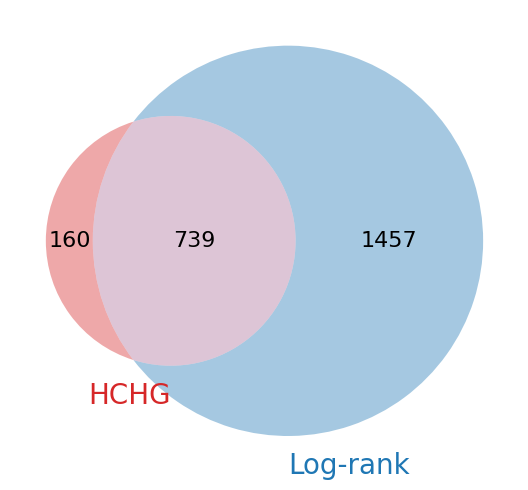

<Figure size 800x600 with 0 Axes>

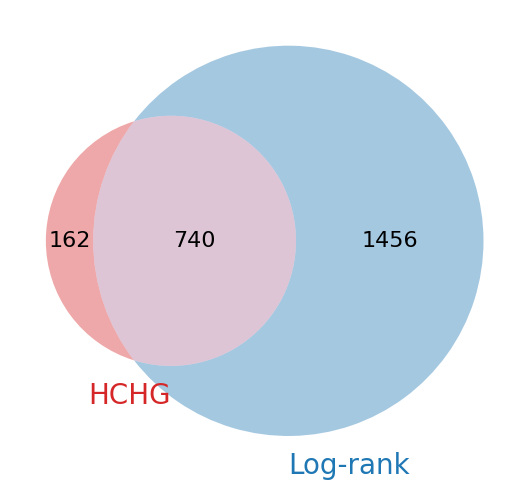

<Figure size 800x600 with 0 Axes>

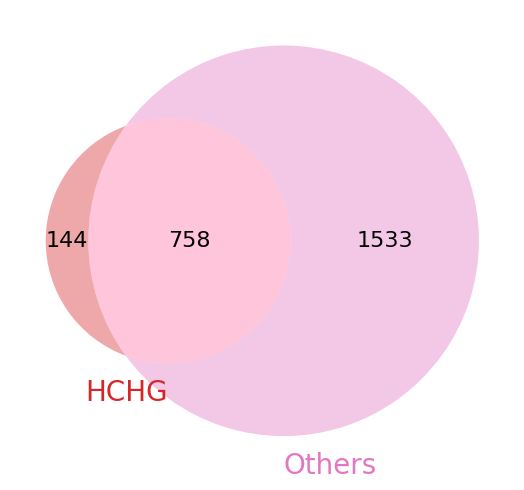

<Figure size 800x600 with 0 Axes>

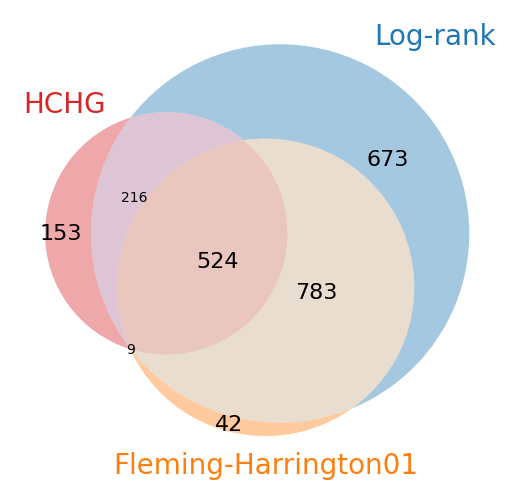

<Figure size 800x600 with 0 Axes>

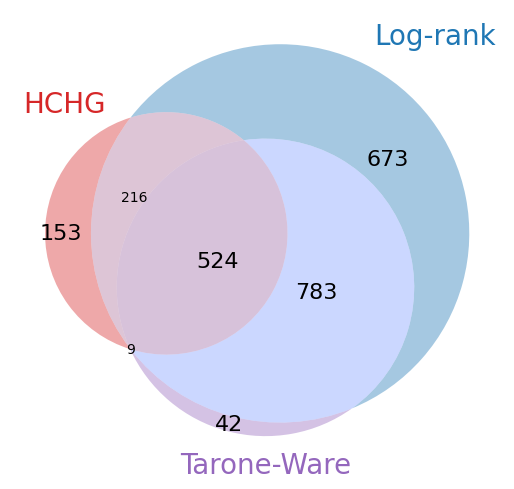

<Figure size 800x600 with 0 Axes>

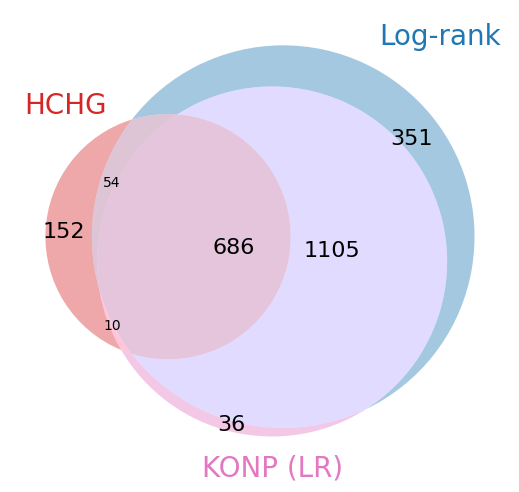

<Figure size 800x600 with 0 Axes>

In [158]:
names = res['name']
s1 = set(names[get_discoverable_by_statistic(res, 'hc_greater', sig_level, side='strict')])
s2 = set(names[get_discoverable_by_statistic(res, 'log_rank_greater', sig_level, side='strict')])
plot_venn2({'hc_greater': s1, 'log_rank_greater': s2})
plt.savefig(output_dir + "venn_HCHG_LR_strict.png",transparent=True, bbox_inches='tight', pad_inches=0)
plt.show()

# either side one-sided

s1 = set(names[get_discoverable_by_statistic(res, 'hc_greater', sig_level, side='either')])
s2 = set(names[get_discoverable_by_statistic(res, 'log_rank_greater', sig_level, side='either')])
plot_venn2({'hc_greater': s1, 'log_rank_greater': s2})
plt.savefig(output_dir + "venn_HCHG_LR_either.png",transparent=True, bbox_inches='tight', pad_inches=0)
plt.show()


# all others
STATS_no_HC = [s for s in STATS if 'hc_' not in s]
s1 = set(names[get_discoverable_by_statistic(res, 'hc_greater', sig_level, side='either')])
s2 = set(names[get_discoverable_by_many_statistics(res, STATS_no_HC, sig_level, side='either')])

plot_venn2({'hc_greater': s1, 'others': s2})

plt.savefig(output_dir + "venn_HCHG_others_either.png",transparent=True, bbox_inches='tight', pad_inches=0)
plt.show()


s1 = set(names[get_discoverable_by_statistic(res, 'hc_greater', sig_level, side='either')])
s2 = set(names[get_discoverable_by_statistic(res, 'log_rank_greater', sig_level, side='either')])
s3 = set(names[get_discoverable_by_statistic(res, 'logrank_lifelines_fleming-harrington01', sig_level, side='either')])

plot_venn3({'hc_greater': s1,
            'log_rank_greater': s2,
            'logrank_lifelines_fleming-harrington01': s3
            })

plt.savefig(output_dir + "venn_others_either_side1.png",transparent=True, bbox_inches='tight', pad_inches=0)
plt.show()

s1 = set(names[get_discoverable_by_statistic(res, 'hc_greater', sig_level, side='either')])
s2 = set(names[get_discoverable_by_statistic(res, 'log_rank_greater', sig_level, side='either')])
s3 = set(names[get_discoverable_by_statistic(res, 'logrank_lifelines_fleming-harrington01', sig_level, side='either')])

plot_venn3({'hc_greater': s1,
            'log_rank_greater': s2,
            'logrank_lifelines_tarone-ware': s3
            })

plt.savefig(output_dir + "venn_others_either_side2.png",transparent=True, bbox_inches='tight', pad_inches=0)
plt.show()

s1 = set(names[get_discoverable_by_statistic(res, 'hc_greater', sig_level, side='either')])
s2 = set(names[get_discoverable_by_statistic(res, 'log_rank_greater', sig_level, side='either')])
s3 = set(names[get_discoverable_by_statistic(res, 'lr_test_stat', sig_level, side='either')])
s4 = set(names[get_discoverable_by_statistic(res, 'chisq_test_stat', sig_level, side='either')])
s5 = set(names[get_discoverable_by_statistic(res, 'cauchy_test_stat', sig_level, side='either')])

plot_venn3({'hc_greater': s1,
            'log_rank_greater': s2,
            'lr_test_stat': s3,
            #'chisq_test_stat': s4,
            #'cauchy_test_stat': s5
            })

plt.savefig(output_dir + "venn_konp_either_side2.png",transparent=True, bbox_inches='tight', pad_inches=0)
plt.show()


### Arrange Results for presentation:

In [159]:
from analyze_gene_expression_results import STATS_TO_DISPLAY
from illustrate_gene_expression_survival_curves import illustrate_survival_curve_gene

In [160]:
res['hc_pval'] = np.minimum(res['hc_greater_pvalue'], res['hc_greater_rev_pvalue'])
res['log_rank_pval'] = np.minimum(res['log_rank_greater_pvalue'], res['log_rank_greater_rev_pvalue'])
res['l-ratio'] = res['hc_pval'] / res['log_rank_pval']

In [161]:
# take only those discovered by HC but not any other

res['hc_pval'] = np.minimum(res['hc_greater_pvalue'], res['hc_greater_rev_pvalue'])
res['log_rank_pval'] = np.minimum(res['log_rank_greater_pvalue'], res['log_rank_greater_rev_pvalue'])
res['l-ratio'] = res['hc_pval'] / res['log_rank_pval']

resi = res[~get_discoverable_by_many_statistics(res, STATS_no_HC, sig_level, side='either')]
resi = resi.sort_values('l-ratio')
resi.head(n=20).name.values

array(['CYTH1', 'EPB41L4B', 'MAP4K2', 'MRPS2', 'OBP2A', 'ATAT1', 'FHL2',
       'DOK4', 'RNF39', 'FHL3', 'OSGIN1', 'NQO2', 'GNA13', 'ARR3', 'FJX1',
       'FUCA1', 'MALL', 'SAMD4A', 'LDHB', 'RCAN1'], dtype=object)

In [162]:
def prepare_for_display(resi):
    flip_idc = resi['hc_greater'] < resi['hc_greater_rev']
    resi['flip'] = '$>$ med'
    resi.loc[flip_idc, 'flip'] = '$<$ med'
    resi['hc'] = np.maximum(resi['hc_greater'], resi['hc_greater_rev'])
    resi['log_rank'] = np.maximum(resi['log_rank_greater'], resi['log_rank_greater_rev'])
    resi['hc_pvalue'] = np.minimum(resi['hc_greater_pvalue'], resi['hc_greater_rev_pvalue'])
    resi['log_rank_pvalue'] = np.minimum(resi['log_rank_greater_pvalue'], resi['log_rank_greater_rev_pvalue'])
    rr = resi.reset_index()#.filter(['name', 'hc', 'hc_pvalue', 'log_rank', 'log_rank_pvalue', 'flip'])
    return rr

resi_disp = prepare_for_display(resi)

ls = resi_disp.name.head(70).tolist()
print("Num = ", len(ls))


Num =  70


#### Illustrate gene and intervals of excessive hazard

In [ ]:
## here: fix the issue with illustrating the results
['CYTH1', 'EPB41L4B', 'MAP4K2', 'MRPS2', 'OBP2A', 'ATAT1', 'FHL2',
       'DOK4', 'RNF39', 'FHL3', 'OSGIN1', 'NQO2', 'GNA13', 'ARR3', 'FJX1',
       'FUCA1', 'MALL', 'SAMD4A', 'LDHB', 'RCAN1']

In [174]:
def illustrate_survival_curve_gene(df, gene_name, T):

    if gene_name not in df.columns:
        logging.error(f"Gene {gene_name} not in dataset.")
        exit(1)
    df_gene = df.filter([gene_name, 'time', 'event'])
    df_gene_T = reduce_time_resolution(df_gene, T=T)
    df_HCT, dfp = illustrate_survival_curve_time2event(df_gene_T.rename(columns={gene_name : 'group'}),
    show_stats_in_title=False, flip_sides=True)
    plt.ylim([0.8, 1.01])

    dfp.index.name = 'time'

    print(df_HCT.columns)
    df_HCT = df_HCT.filter(['at-risk:0', 'at-risk:1', 'observed:0', 'observed:1', 'pvalue'])
    df_HCT.index = df_HCT.index.astype(int)
    
    for l in ['at-risk:0', 'at-risk:1', 'observed:0', 'observed:1']:
        df_HCT[l] = df_HCT[l].astype(int)
    
    return dfp, df_HCT


Index(['MAP4K2', 'time', 'event'], dtype='object')


KeyError: 'at-risk:0'

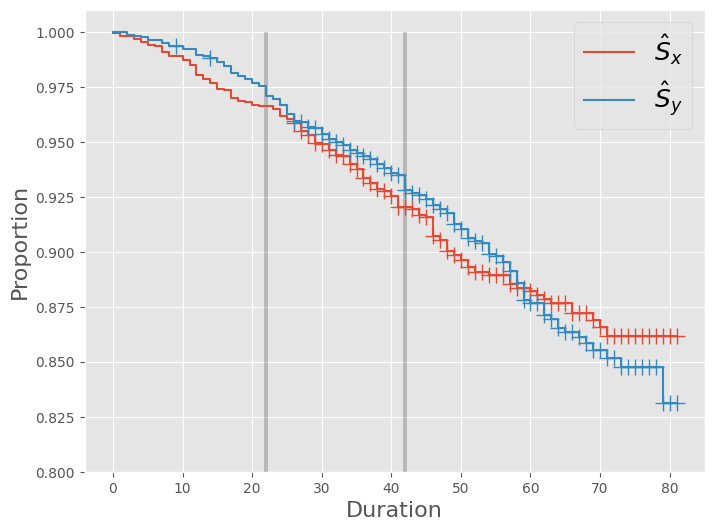

In [175]:
illustrate_survival_curve_gene(df, "MAP4K2", T=82)
plt.ylim([0.8,1])
plt.show()

INFO:root:Flipped sides


Saved figure to Figs/FAM20B_survival.png.


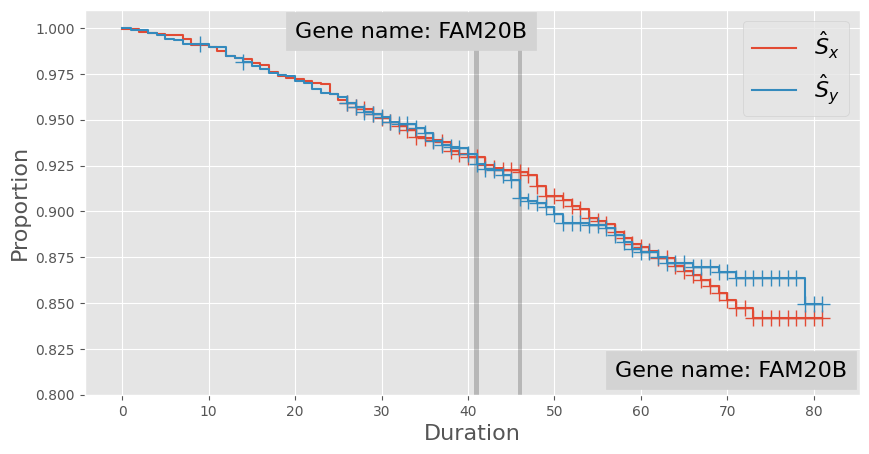

INFO:root:Flipped sides


Saved figure to Figs/PBX1_survival.png.


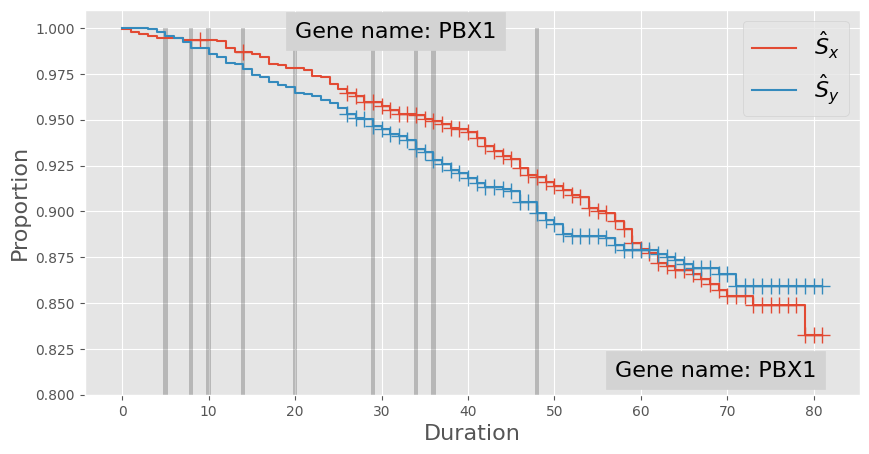

INFO:root:Flipped sides


Saved figure to Figs/CRADD_survival.png.


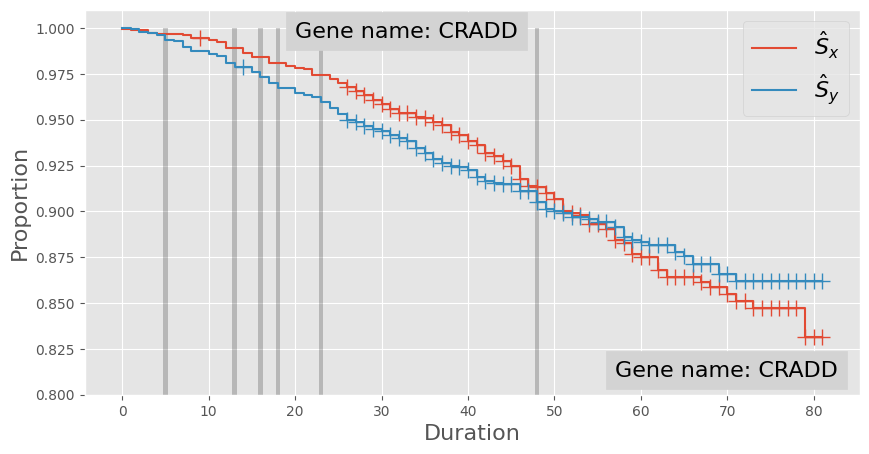

Saved figure to Figs/MBD3_survival.png.


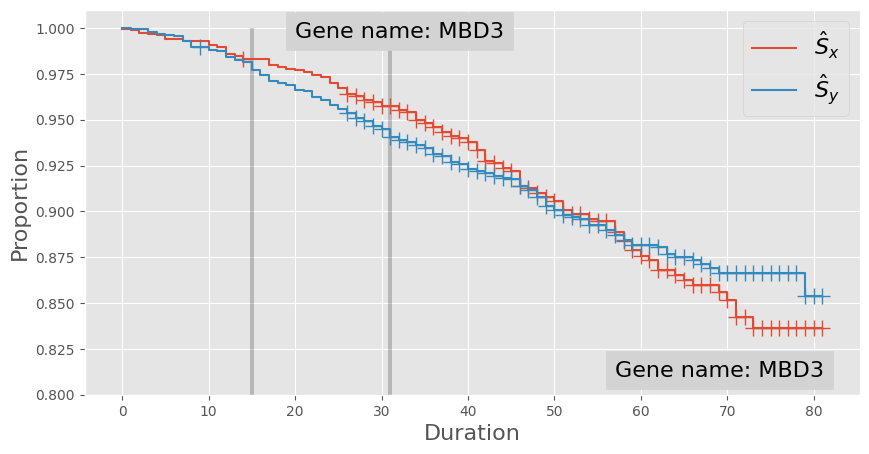

Saved figure to Figs/EPB41L4B_survival.png.


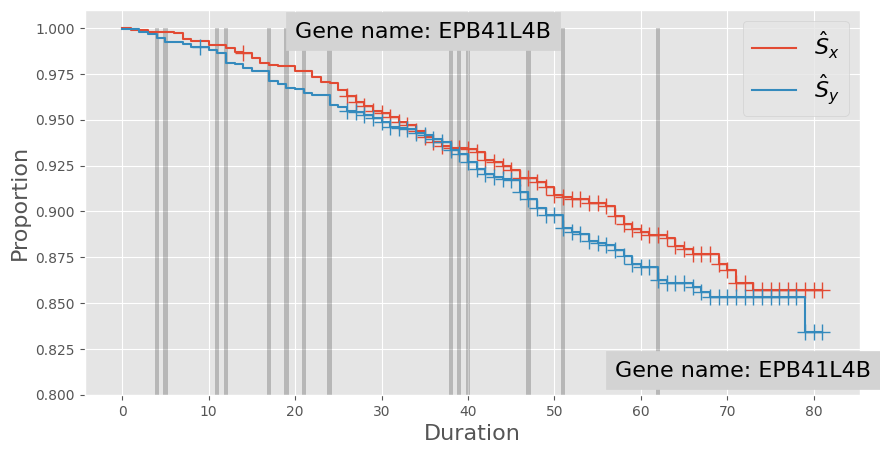

INFO:root:Flipped sides


Saved figure to Figs/ANKLE2_survival.png.


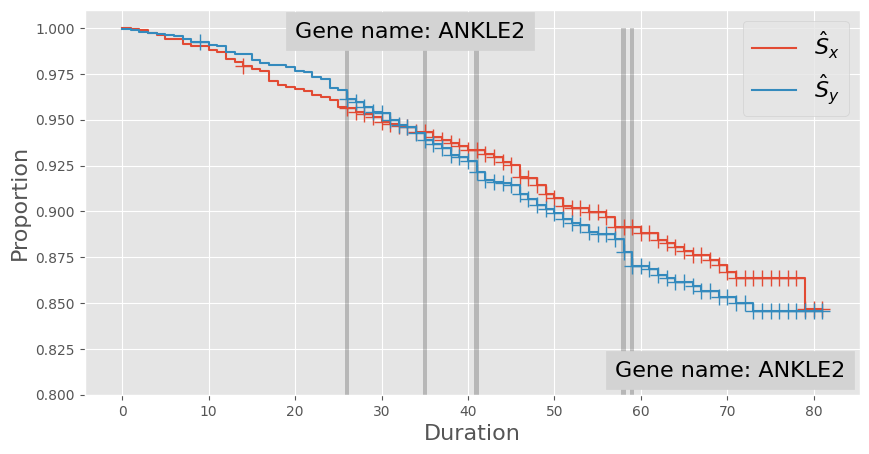

INFO:root:Flipped sides


Saved figure to Figs/DDX5_survival.png.


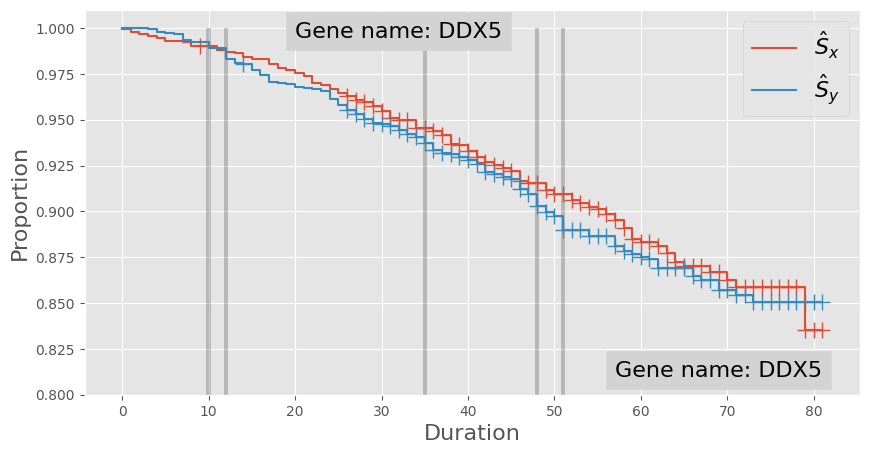

Saved figure to Figs/MRAS_survival.png.


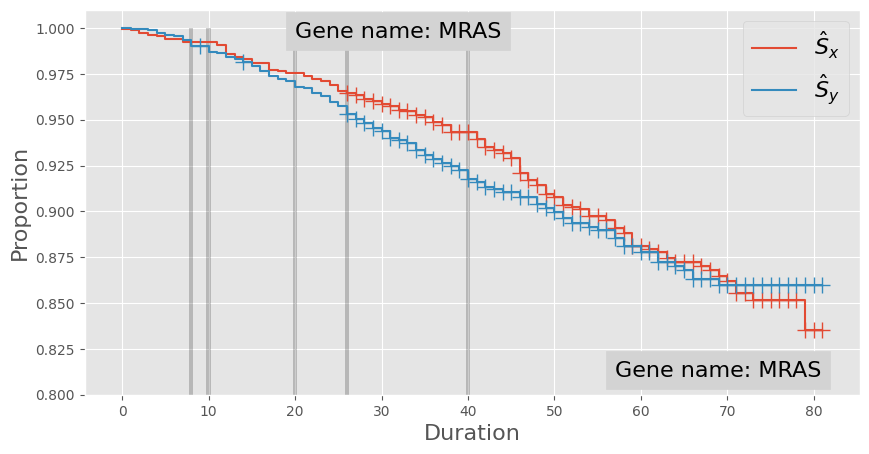

INFO:root:Flipped sides


Saved figure to Figs/CLCF1_survival.png.


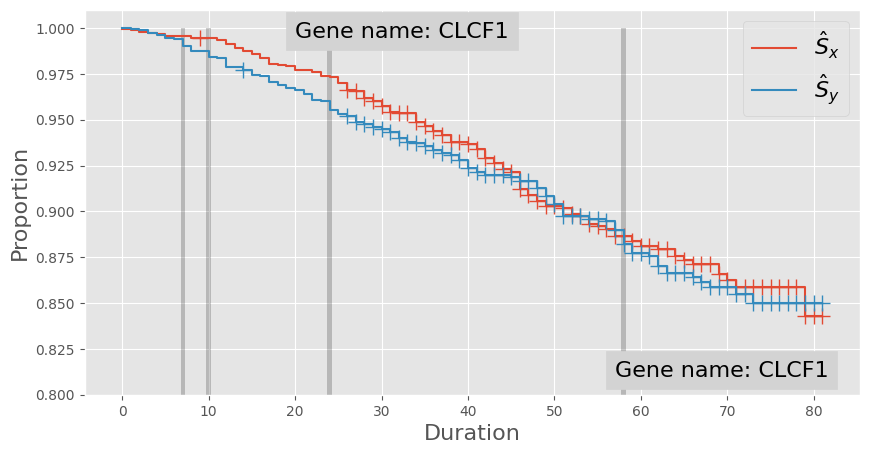

Saved figure to Figs/MALL_survival.png.


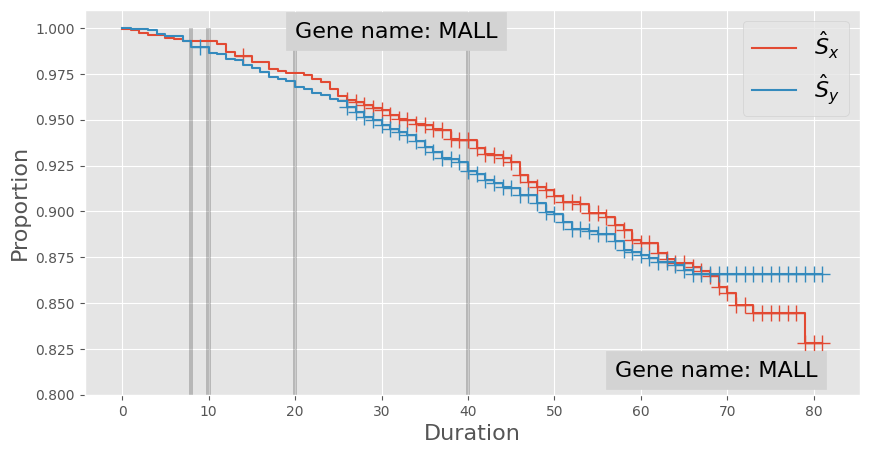

In [47]:
from analyze_gene_expression_results import SELECTED_GENES, get_pvals_for_gene
SELECTED_GENES = ['FAM20B', 'PBX1', 'CRADD', 'MBD3', 'EPB41L4B', 'ANKLE2', 'DDX5', 'MRAS', 'CLCF1', 'MALL']

OUTPUT_DIR_FIGS = "Figs"
#OUTPUT_DIR_CSV = "/Users/kipnisal/Dropbox/Apps/Overleaf/Survival Analysis with Sensitivity to Possible Rare and Weak Differences/csv"
OUTPUT_DIR_CSV = "csv"

for gene_name in SELECTED_GENES:
    plt.figure(figsize=(10, 5))
    _, df_HCT = illustrate_survival_curve_gene(df, gene_name, T)
    plt.text(int(T - 25), .81, f"Gene name: {gene_name}", backgroundcolor='lightgray', fontsize=16)
    plt.legend(loc='upper right', fontsize=16)
    plt.ylim([0.8, 1.01])

    fig_filename = OUTPUT_DIR_FIGS + f"/{gene_name}.png"
    plt.savefig(fig_filename, dpi=300, bbox_inches='tight', pad_inches=0.05)
    print(f"Saved figure to {fig_filename}.")
    plt.show()
    df_HCT.to_csv(f"{OUTPUT_DIR_CSV}/{gene_name}_HCT.csv")

    #df_pvals = get_pvals_for_gene(resi_disp, gene_name)
    #df_pvals.to_csv(f"{output_dir}csv/{gene_name}_pvals.csv")
    

#### Todo: 
- Fix the functions below to include all information for testing; use the lifeline notation

,removed:0,removed:1,observed Y,observed X,censored:1,censored:0,at_risk Y,at_risk X,pvalue,pvalue_rev
event_at,,,,,,,,,,
7.0,6.0,0.0,6.0,0.0,0.0,0.0,1527.0,1526.0,0.015579,1.0
8.0,5.0,0.0,5.0,0.0,0.0,0.0,1521.0,1526.0,0.030892,1.0
10.0,5.0,0.0,5.0,0.0,0.0,0.0,1516.0,1525.0,0.030688,1.0
20.0,5.0,0.0,5.0,0.0,0.0,0.0,1488.0,1497.0,0.030678,1.0
29.0,19.0,16.0,6.0,0.0,13.0,16.0,1406.0,1414.0,0.015279,1.0


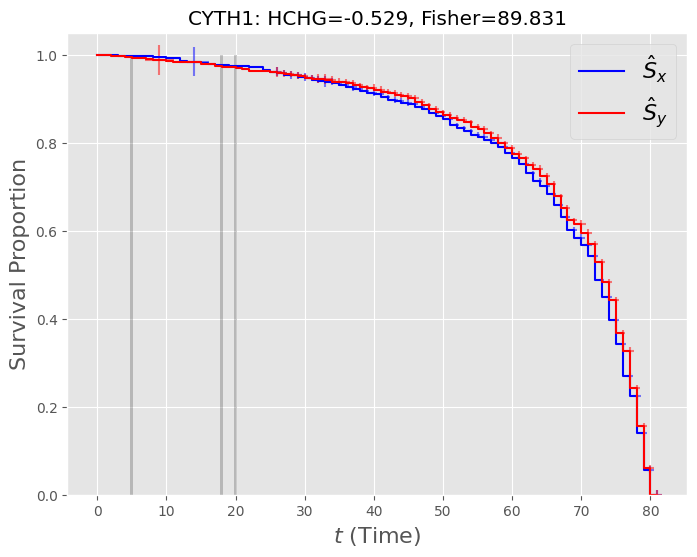

In [183]:
def HCHG_survival_analysis(Nt1, Nt2, Ot1, Ot2, randomize=False, stbl=stbl):

    pvals = multi_pvals(Nt1, Nt2, Ot1, Ot2, randomize=randomize)
    mt = MultiTest(pvals[pvals<1], stbl=stbl) 
    hc, hct = mt.hc(gamma=.2)
    fisher = mt.fisher()
        
    fpval = pvals <= hct
    
    dfg['pvalue'] = pvals
    dfg['t'] = np.arange(0,len(Ot1))

    cumc1 = dfg['censored:0'].cumsum()
    cumc2 = dfg['censored:1'].cumsum()
    dfg['Survival Proportion X'] = (dfg['at_risk:0'] - dfg['censored:0']) / (dfg['at_risk:0'].max() - cumc1)
    dfg['Survival Proportion Y'] = (dfg['at_risk:1'] - dfg['censored:1']) / (dfg['at_risk:1'].max() - cumc2)
        
    dfg['suspected'] = fpval
    return dfg.set_index('t'), hc, fisher[0]

def HCHG_survival_analysis_full(Nt1, Nt2, Ot1, Ot2, randomize=False, stbl=stbl):
    
    dfg, hc, fisher = HCHG_survival_analysis(Nt1, Nt2, Ot1, Ot2, randomize=randomize, stbl=stbl)
    
    fpval = dfg.suspected
    plt.step(dfg.index, dfg['Survival Proportion X'], 'b', where='pre')
    plt.step(dfg.index, dfg['Survival Proportion Y'], 'r', where='pre')
    ct1 = dfg['censored:0'] > 0
    ct2 = dfg['censored:1'] > 0
    s1 = 10 * (dfg.loc[ct1, 'censored:0'].max() / dfg.loc[ct1, 'censored:0']).values
    s2 = 10 * (dfg.loc[ct2, 'censored:1'].max() / dfg.loc[ct2, 'censored:1']).values
    plt.scatter(dfg.index[ct1], dfg.loc[ct1,'Survival Proportion X'],
                marker='+', c='b',
                s=s1, alpha=.5)
    plt.scatter(dfg.index[ct2], dfg.loc[ct2,'Survival Proportion Y'],
                marker='+', c='r',
                s=s2, alpha=.5)
    
    plt.legend([r'$\hat{S}_x$', r'$\hat{S}_y$'], fontsize=16, loc=1)
    
    plt.bar(dfg.index[:len(fpval)], fpval, color='k', alpha=.2, width=.5)

    plt.title(rf"{gene_name}: HCHG={np.round(hc,3)}, Fisher={np.round(fisher,3)}")
    plt.ylabel('Survival Proportion', fontsize=16)
    plt.xlabel(r'$t$ (Time)', fontsize=16)
    #plt.ylim([0.7, 1.01])
    
    return dfg


gene_name = 'CYTH1'
stbl=True
T = 82

from test_gene_expression import reduce_time_resolution, two_groups_table
from survival import multi_pvals

data_con = reduce_time_resolution(df[['time', 'event', gene_name]], T=T)
dfg = two_groups_table(data_con, gene_name)

Nt1, Nt2 = dfg['at_risk:0'].values, dfg['at_risk:1'].values
Ot1, Ot2 = dfg['observed:0'].values, dfg['observed:1'].values

dft = HCHG_survival_analysis_full(Nt1, Nt2, Ot1, Ot2)
dft

dfp_HCT

In [163]:
plt.rcParams['figure.figsize'] =  [12, 6]
plt.rcParams["figure.dpi"] = 200

list_to_plot = resi_disp.name.values
list_to_plot = ['TRPS1']

for gene_name in list_to_plot:
    df_disp, dfp = illustrate_survival_curve(df, df0, gene_name, T, stbl=True)
    plt.savefig(output_dir + "Figs/"  + gene_name + ".png")
    plt.show()

    dfd = df_disp.copy()
    dfd = dfd.iloc[:, :-2]

    for tag in ['pvalue', 'pvalue_rev']:
        dfd[tag] = np.round(dfd[tag],3)

    for tag in ['at_risk X', 'at_risk Y', 'events X', 'events Y']:
        dfd[tag] = dfd[tag].astype(int)

    dfd.index.name = 'time'
    dfd.filter(['at_risk X', 'at_risk Y', 'events X', 'events Y', 'pvalue', 'pvalue_rev'])\
        .to_csv(output_dir + "csv/" + f'{gene_name}.csv')


NameError: name 'resi_disp' is not defined

## Randomized P-values

In [375]:
resm = pd.read_csv("SCANB_True_T100_randomized_rep100.csv")

def rate_succ(xx):
    t = 1.41
    return np.mean(xx > t)

def pval_binom(x, n, p=sig_level):
    return np.binom.sf(x, n=100, p=p)

hc_sum = resm.groupby('name').hc_greater.agg(['mean', q95, rate_succ, 'count'])
hc_sum.sort_values('rate_succ', ascending=False).apply(pval_binom() )

,mean,q95,rate_succ,count
name,,,,
MTR,2.142463,2.672658,0.99,100
TRPS1,2.181579,2.805051,0.96,100
C11orf68,1.988362,2.613434,0.94,100
HIST1H4A,1.934908,2.484923,0.93,100
FBXL12,1.940221,2.612060,0.92,100
...,...,...,...,...
COX7C,0.379212,1.285728,0.00,100
DEDD,-0.035174,0.900712,0.00,100
LSS,0.096871,0.955187,0.00,100
